In [ ]:
# Block 1: Mount Drive and Define Paths
from google.colab import drive
import os
import pandas as pd
import yaml

# Mount Google Drive
drive.mount('/content/drive')

# Define the base directory for your project
base_dir = '/content/drive/MyDrive/DL_project/project'

# Define paths to data, images, and metadata files
data_dir = os.path.join(base_dir, 'data')
images_dir = os.path.join(data_dir, 'images')
classes_file = os.path.join(data_dir, 'classes.txt')
labels_file = os.path.join(data_dir, 'labels_fixed.csv')
attributes_file = os.path.join(data_dir, 'attributes.yaml')

# Verify that the critical paths exist before proceeding
assert os.path.exists(data_dir), f"Data directory not found: {data_dir}"
assert os.path.exists(images_dir), f"Images directory not found: {images_dir}"
assert os.path.exists(classes_file), f"Classes file not found: {classes_file}"
assert os.path.exists(labels_file), f"Labels CSV file not found: {labels_file}"

print("All paths verified successfully.")


Mounted at /content/drive
All paths verified successfully.


In [ ]:
# Block 2: Load Metadata

# Read the class names from classes.txt
with open(classes_file, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

# Load the labels and file information from the CSV
labels_df = pd.read_csv(labels_file)

# Create a mapping from class name to integer index
class_to_idx = {name: i for i, name in enumerate(class_names)}

print(f"Successfully loaded {len(class_names)} classes.")
print("Labels DataFrame head:")
print(labels_df.head())


Successfully loaded 10 classes.
Labels DataFrame head:
                          image_path           class_label  \
0  images\team14_wrist_watch (1).jpg  clothing_wrist_watch   
1  images\team14_wrist_watch (2).jpg  clothing_wrist_watch   
2  images\team14_wrist_watch (3).jpg  clothing_wrist_watch   
3  images\team14_wrist_watch (4).jpg  clothing_wrist_watch   
4  images\team14_wrist_watch (5).jpg  clothing_wrist_watch   

                                          attributes  \
0  color:black;material:unknown;condition:new;siz...   
1  color:black;material:plastic;condition:new;siz...   
2  color:yellow;material:metal;condition:new;size...   
3  color:black;material:unknown;condition:new;siz...   
4  color:black;material:unknown;condition:new;siz...   

                                       caption  split           instance_id  \
0             new small black wrist watch face  train   Team14_BlackWatch_A   
1     new small black plastic watch from side   train   Team14_BlackWatch_B  

In [ ]:
# --- Block 3 & 4: Redefine Class and Re-create Datasets ---

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import DeiTImageProcessor
from PIL import Image
import os

# 1. Corrected CustomImageDataset Class
class CustomImageDataset(Dataset):
    def __init__(self, df, base_dir, class_map, transform=None):
        self.df = df
        self.base_dir = base_dir
        self.class_map = class_map
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        relative_path = row['image_path'].replace('\\', '/')
        img_path = os.path.join(self.base_dir, relative_path)
        image = Image.open(img_path).convert("RGB")
        label = self.class_map[row['class_label']]
        if self.transform:
            image = self.transform(image)
        return image, label

# 2. Re-create the Datasets with the Corrected Class
processor = DeiTImageProcessor.from_pretrained('facebook/deit-tiny-patch16-224')
transform = transforms.Compose([
    transforms.Resize((processor.size['height'], processor.size['width'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

data_folder_path = os.path.join(base_dir, 'data')
full_dataset = CustomImageDataset(df=labels_df, base_dir=data_folder_path, class_map=class_to_idx, transform=transform)

# Split data
train_size = 800
val_size = 200
train_dataset, val_dataset, _ = random_split(full_dataset, [train_size, val_size, len(full_dataset) - (train_size + val_size)], generator=torch.Generator().manual_seed(42))

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("SUCCESS: Datasets and DataLoaders are correctly defined and ready.")


SUCCESS: Datasets and DataLoaders are correctly defined and ready.


In [ ]:
# Block 5: Model Setup with Tuned Hyperparameters
import torch.nn as nn
from transformers import ViTForImageClassification
import torch
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model, ensuring 'class_names' from your DL_project setup is available
model = ViTForImageClassification.from_pretrained(
    'facebook/deit-tiny-patch16-224',
    num_labels=len(class_names),
    ignore_mismatched_sizes=True
)
model.to(device)

# --- Hyperparameter Adjustments for Overfitting ---
# 1. Lower learning rate for more stable convergence
# 2. Increased weight decay for stronger regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.1)

# 3. Learning rate scheduler to decrease LR over time
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

criterion = nn.CrossEntropyLoss()

print("Model re-initialized for DL_project with tuned hyperparameters.")



config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model re-initialized for DL_project with tuned hyperparameters.


In [ ]:
# Block 6 : Training and Evaluation with Loss, Accuracy, and F1 Score
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
import torch

# Ensure you have scikit-learn installed
# !pip install -q scikit-learn

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for imgs, labels in tqdm(dataloader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    # Calculate both accuracy and F1 score
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Validation"):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs.logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    # Calculate both accuracy and F1 score
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1


In [ ]:
# Block 7 : Training Loop with Scheduler


num_epochs = 12 # Increased epochs to allow for slower learning
print("Starting fine-tuning process with adjusted hyperparameters...")

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)

    # Evaluate on the validation set
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)

    # --- IMPORTANT: Step the scheduler after the epoch ---
    scheduler.step()

    # Print all metrics
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"LR: {optimizer.param_groups[0]['lr']:.1e} | " # Display current learning rate
        f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
        f"Val -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}"
    )

print("\nFine-tuning complete.")


Starting fine-tuning process with adjusted hyperparameters...


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/12 | LR: 1.0e-05 | Train -> Loss: 2.2112, Acc: 0.2162, F1: 0.2150 | Val -> Loss: 2.0670, Acc: 0.3550, F1: 0.3460


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/12 | LR: 1.0e-05 | Train -> Loss: 1.8141, Acc: 0.5150, F1: 0.4838 | Val -> Loss: 1.7450, Acc: 0.5450, F1: 0.5241


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/12 | LR: 1.0e-05 | Train -> Loss: 1.4071, Acc: 0.7212, F1: 0.7059 | Val -> Loss: 1.4305, Acc: 0.6650, F1: 0.6596


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/12 | LR: 1.0e-05 | Train -> Loss: 1.0651, Acc: 0.8413, F1: 0.8355 | Val -> Loss: 1.1878, Acc: 0.7500, F1: 0.7373


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/12 | LR: 1.0e-06 | Train -> Loss: 0.7950, Acc: 0.9350, F1: 0.9338 | Val -> Loss: 0.9985, Acc: 0.8050, F1: 0.7982


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/12 | LR: 1.0e-06 | Train -> Loss: 0.6424, Acc: 0.9688, F1: 0.9685 | Val -> Loss: 0.9833, Acc: 0.8150, F1: 0.8086


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/12 | LR: 1.0e-06 | Train -> Loss: 0.6226, Acc: 0.9738, F1: 0.9735 | Val -> Loss: 0.9680, Acc: 0.8100, F1: 0.8006


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/12 | LR: 1.0e-06 | Train -> Loss: 0.6038, Acc: 0.9788, F1: 0.9787 | Val -> Loss: 0.9528, Acc: 0.8150, F1: 0.8078


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/12 | LR: 1.0e-06 | Train -> Loss: 0.5859, Acc: 0.9812, F1: 0.9812 | Val -> Loss: 0.9384, Acc: 0.8100, F1: 0.7987


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/12 | LR: 1.0e-07 | Train -> Loss: 0.5684, Acc: 0.9825, F1: 0.9825 | Val -> Loss: 0.9236, Acc: 0.8300, F1: 0.8257


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/12 | LR: 1.0e-07 | Train -> Loss: 0.5560, Acc: 0.9838, F1: 0.9837 | Val -> Loss: 0.9222, Acc: 0.8300, F1: 0.8257


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/12 | LR: 1.0e-07 | Train -> Loss: 0.5543, Acc: 0.9838, F1: 0.9837 | Val -> Loss: 0.9208, Acc: 0.8300, F1: 0.8257

Fine-tuning complete.


In [ ]:
torch.save(model.state_dict(), 'best_model_original.pth')

model.load_state_dict(torch.load('best_model_original.pth'))

<All keys matched successfully>

In [ ]:
# --- Retrieval Block 1: Generate and Save Embeddings ---

import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from tqdm.notebook import tqdm
import os

# 1. Initialize Models and Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model_name = "openai/clip-vit-base-patch32"

print("Loading CLIP model and processor for embedding generation...")
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
print("CLIP model loaded.")

# 2. Function to Pre-compute and Save Embeddings
def compute_and_save_embeddings(image_dataset, save_path):
    """
    Generates CLIP embeddings for all images in a dataset and saves them to a file.
    """
    clip_model.eval()
    all_embeddings = []
    all_image_paths = []

    with torch.no_grad():
        for i in tqdm(range(len(image_dataset)), desc="Generating Embeddings"):
            subset_idx = image_dataset.indices[i]
            row = image_dataset.dataset.df.iloc[subset_idx]
            base_dir = image_dataset.dataset.base_dir

            relative_path = row['image_path'].replace('\\', '/')
            img_path = os.path.join(base_dir, relative_path)

            image = Image.open(img_path).convert("RGB")
            image_inputs = clip_processor(images=image, return_tensors="pt").to(device)
            image_features = clip_model.get_image_features(**image_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            all_embeddings.append(image_features.cpu().numpy())
            all_image_paths.append(img_path)

    embeddings_array = np.vstack(all_embeddings)
    np.savez_compressed(save_path, embeddings=embeddings_array, image_paths=all_image_paths)
    print(f"Embeddings for {len(all_image_paths)} images saved to {save_path}")


embeddings_file_path = os.path.join(base_dir, 'validation_embeddings.npz')

# Uncomment the line below and run this cell to create the file.
compute_and_save_embeddings(val_dataset, embeddings_file_path)

print("\nBlock 1 is ready. Uncomment the final line to generate embeddings.")


Loading CLIP model and processor for embedding generation...
CLIP model loaded.


Generating Embeddings:   0%|          | 0/200 [00:00<?, ?it/s]

Embeddings for 200 images saved to /content/drive/MyDrive/DL_project/project/validation_embeddings.npz

Block 1 is ready. Uncomment the final line to generate embeddings.


Loading CLIP model and processor for retrieval...
CLIP model loaded.

Top 3 results for the query: 'a used blue plastic water bottle'

--- Rank 1 | Similarity Score: 0.3210 ---


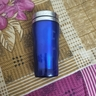


--- Rank 2 | Similarity Score: 0.2941 ---


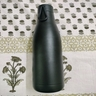


--- Rank 3 | Similarity Score: 0.2933 ---


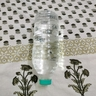

In [ ]:
# --- Retrieval Block 2: Search Using Saved Embeddings ---

import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from IPython.display import display
import os

# 1. Initialize Models and Device (needed for encoding the text query)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model_name = "openai/clip-vit-base-patch32"

print("Loading CLIP model and processor for retrieval...")
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
print("CLIP model loaded.")

# 2. Function to Retrieve Top 3 Images
def find_top_3_fast(text_query, embeddings_path):
    """
    Performs a fast search using pre-computed embeddings to find the top 3 matches.
    """
    saved_data = np.load(embeddings_path)
    image_embeddings = torch.from_numpy(saved_data['embeddings']).to(device)
    image_paths = saved_data['image_paths']

    with torch.no_grad():
        text_inputs = clip_processor(text=[text_query], return_tensors="pt").to(device)
        text_features = clip_model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarities = (text_features @ image_embeddings.T).squeeze(0)
        top_scores, top_indices = torch.topk(similarities, k=3)

    results = []
    for score, idx in zip(top_scores.cpu().tolist(), top_indices.cpu().tolist()):
        image = Image.open(image_paths[idx]).convert("RGB")
        results.append((score, image))

    return results

# 3. Example Execution
# Assumes 'base_dir' is defined from your training blocks.
embeddings_file_path = os.path.join(base_dir, 'validation_embeddings.npz')

try:
    query = "a used blue plastic water bottle"
    top_matches = find_top_3_fast(query, embeddings_file_path)

    print(f"\nTop 3 results for the query: '{query}'")
    if top_matches:
        for rank, (score, img) in enumerate(top_matches, 1):
            print(f"\n--- Rank {rank} | Similarity Score: {score:.4f} ---")
            display(img)
except FileNotFoundError:
    print(f"Error: Embeddings file not found at '{embeddings_file_path}'.")
    print("Please run Retrieval Block 1 first to generate the embeddings file.")


In [ ]:
# --- Analysis Block 1: Get Predictions and Features ---

import torch
import numpy as np
from tqdm.notebook import tqdm

# Ensure the model is in evaluation mode
model.eval()

all_preds = []
all_labels = []
all_features = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Getting Predictions and Features"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Get model outputs
        # output_hidden_states=True is needed to get the feature embeddings
        outputs = model(imgs, output_hidden_states=True)

        # Get the feature embeddings from the last hidden layer ([CLS] token)
        # This is the representation the classifier uses
        features = outputs.hidden_states[-1][:, 0].cpu().numpy()
        all_features.append(features)

        # Get predictions
        preds = outputs.logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for analysis
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_features = np.vstack(all_features)

print("\nSUCCESS: Predictions and features have been extracted from the validation set.")
print(f"Features shape: {all_features.shape}")


Getting Predictions and Features:   0%|          | 0/7 [00:00<?, ?it/s]


SUCCESS: Predictions and features have been extracted from the validation set.
Features shape: (200, 192)


--- Classification Report ---
                                      precision    recall  f1-score   support

              tableware_water_bottle       0.89      0.89      0.89        18
                      stationary_pen       0.96      0.92      0.94        24
                 stationary_notebook       0.86      1.00      0.93        25
electronic_accessories_phone_charger       0.73      0.89      0.80        18
    electronic_accessories_earphones       0.72      0.76      0.74        17
            personal_care_toothbrush       0.91      1.00      0.95        21
              personal_care_soap_bar       0.80      0.80      0.80        25
        personal_care_shampoo_bottle       0.92      0.58      0.71        19
                clothing_wrist_watch       0.92      0.55      0.69        20
                   footware_slippers       0.61      0.85      0.71        13

                            accuracy                           0.83       200
                           macro

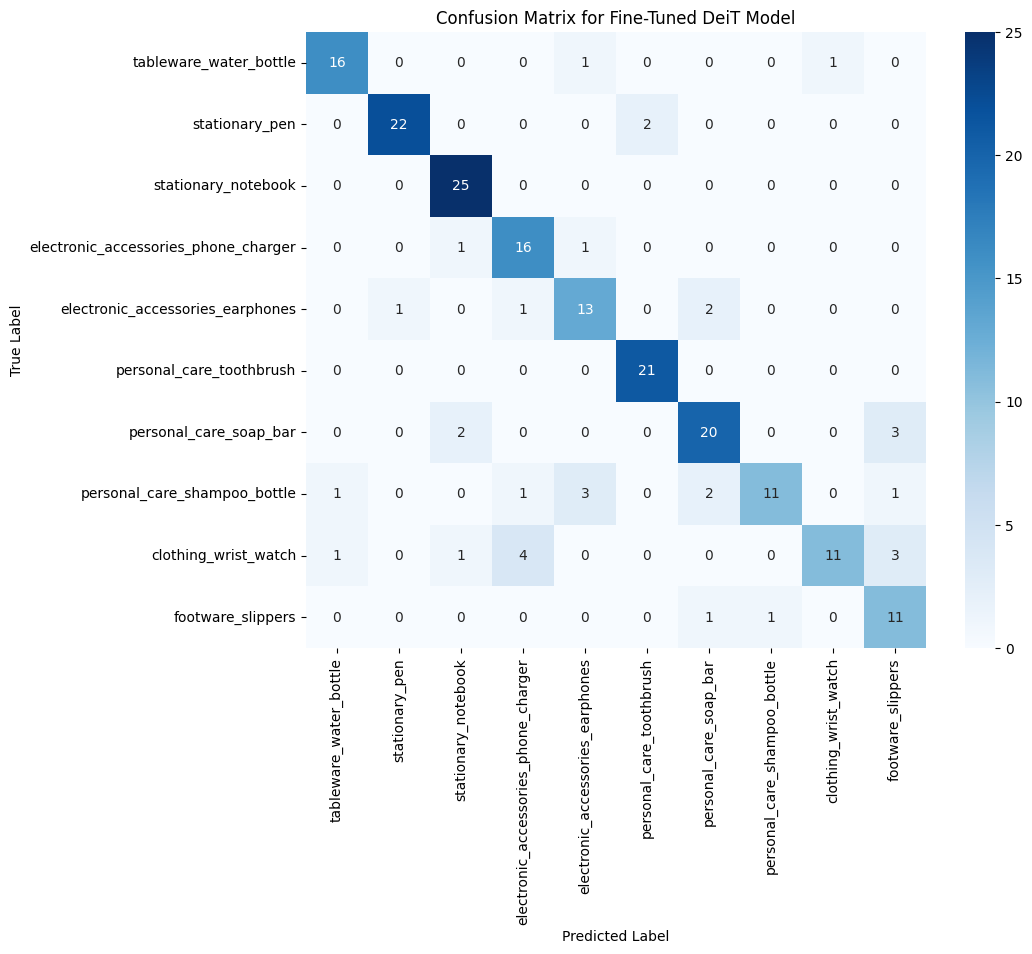

In [ ]:
# --- Analysis Block 2: Classification Report and Confusion Matrix ---

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Print Per-Class and Overall Scores
print("--- Classification Report ---")
# This provides accuracy, precision, recall, and F1-score for each class
report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
print(report)

# 2. Plot the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fine-Tuned DeiT Model')
plt.show()


Running t-SNE... (This may take a moment)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


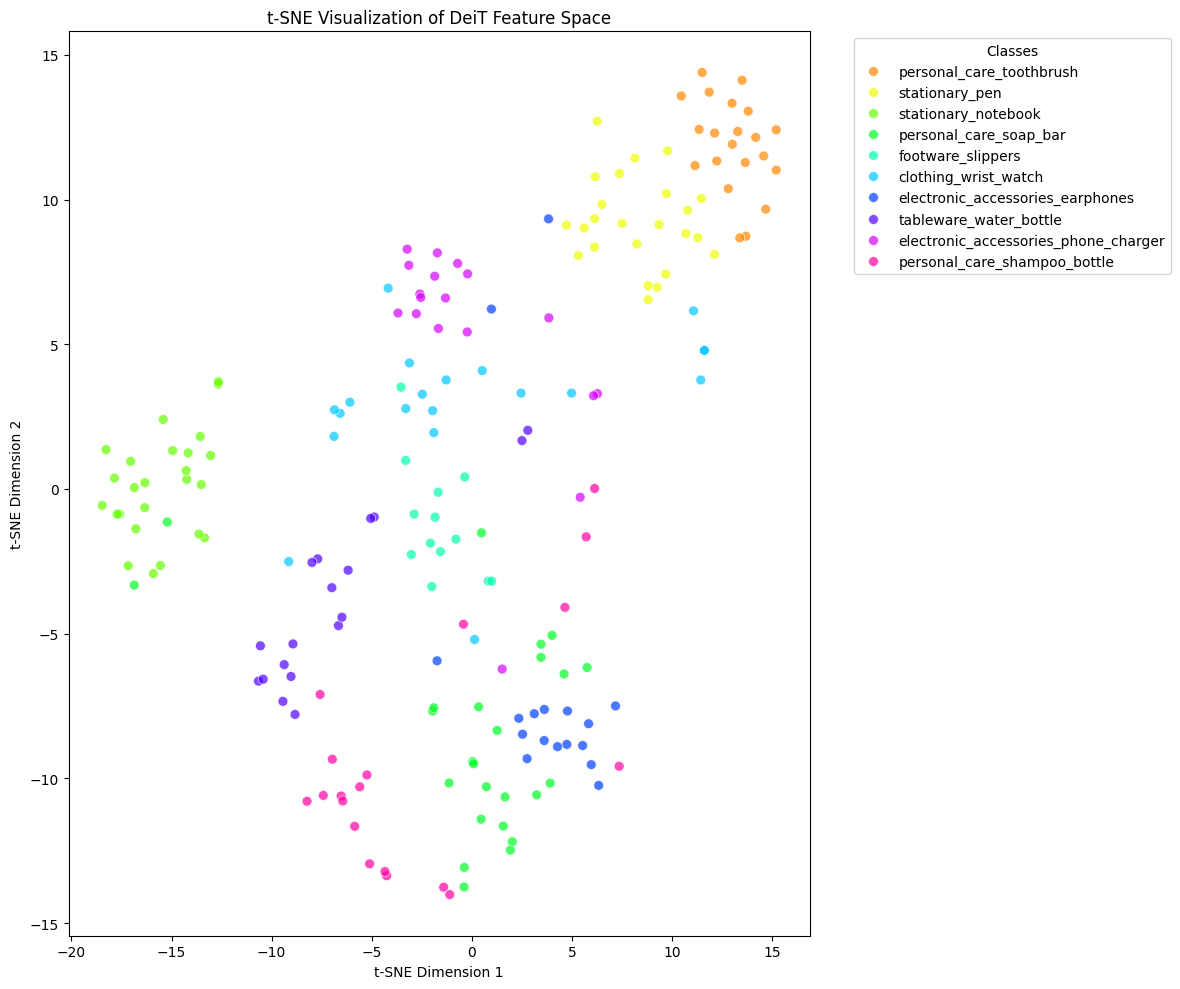


Running PCA...


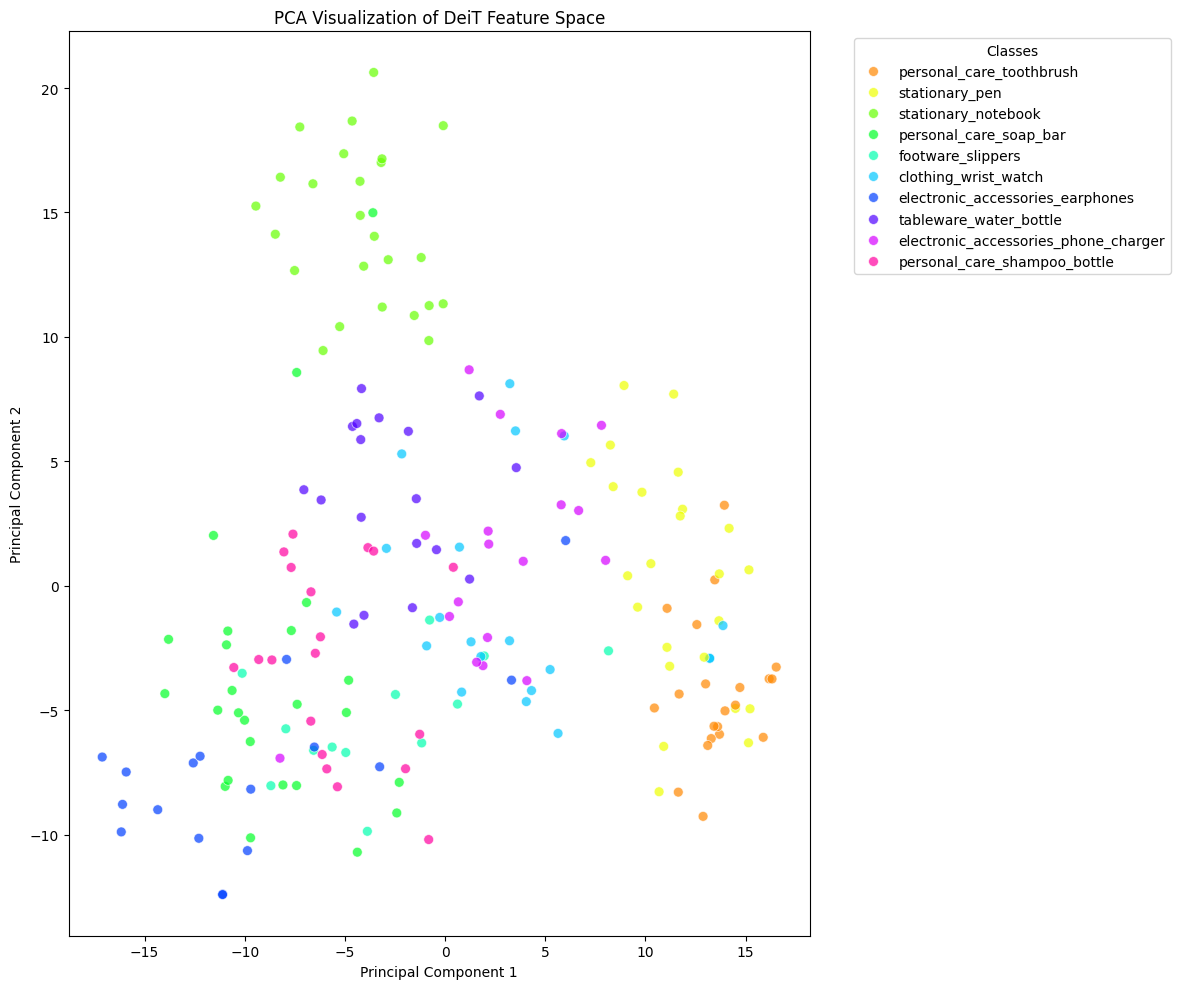

In [ ]:
# --- Analysis Block 5: t-SNE and PCA Feature Visualization ---

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# --- 1. Function to Plot t-SNE ---
def plot_tsne(features, labels, class_names):
    """
    Computes and plots a t-SNE visualization of high-dimensional feature data.
    """
    print("Running t-SNE... (This may take a moment)")
    # Initialize t-SNE. Perplexity is a key parameter;
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features)

    # Plot the 2D features
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue=[class_names[i] for i in labels],
        palette=sns.color_palette("hsv", len(class_names)),
        s=50,
        alpha=0.7
    )
    plt.title('t-SNE Visualization of DeiT Feature Space')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- 2. Function to Plot PCA ---
def plot_pca(features, labels, class_names):
    """
    Computes and plots a PCA visualization of high-dimensional feature data.
    """
    print("\nRunning PCA...")
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    # Plot the 2D features
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue=[class_names[i] for i in labels],
        palette=sns.color_palette("hsv", len(class_names)),
        s=50,
        alpha=0.7
    )
    plt.title('PCA Visualization of DeiT Feature Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- 3. Example Usage ---


# Generate the t-SNE plot
plot_tsne(all_features, all_labels, class_names)

# Generate the PCA plot
plot_pca(all_features, all_labels, class_names)
